# Eclipse VFP Lift Curve Generation - Manifold Pressure Control

Generate Eclipse-compatible VFP lift curves with **manifold outlet pressure control** using parallel execution.

**Key Features:**
- Target **manifold outlet pressure** (not compressor outlet) to account for piping losses
- **Parallel execution** (~4x speedup) using independent process systems per worker
- **Split factor optimization** for load balancing across 3 compressor trains
- **Compressor map visualization** with operating points

**Operating Envelope:** Manifold pressures 100-130 bara, Flow rates 30-70 MSm³/day

In [1]:
# === IMPORTS AND CONFIGURATION ===
import neqsim
from neqsim import jneqsim
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
from scipy.optimize import minimize
from scipy.spatial import ConvexHull
from concurrent.futures import ThreadPoolExecutor, as_completed
import time, os, json

# Java classes
SystemPrEos = jneqsim.thermo.system.SystemPrEos
ProcessSystem = jneqsim.process.processmodel.ProcessSystem
Stream = jneqsim.process.equipment.stream.Stream
Splitter = jneqsim.process.equipment.splitter.Splitter
Compressor = jneqsim.process.equipment.compressor.Compressor
CompressorDriver = jneqsim.process.equipment.compressor.CompressorDriver
DriverType = jneqsim.process.equipment.compressor.DriverType
Separator = jneqsim.process.equipment.separator.Separator
ThreePhaseSeparator = jneqsim.process.equipment.separator.ThreePhaseSeparator
PipeBeggsAndBrills = jneqsim.process.equipment.pipeline.PipeBeggsAndBrills
Manifold = jneqsim.process.equipment.manifold.Manifold
StreamSaturatorUtil = jneqsim.process.equipment.util.StreamSaturatorUtil
Mixer = jneqsim.process.equipment.mixer.Mixer
Pump = jneqsim.process.equipment.pump.Pump
Cooler = jneqsim.process.equipment.heatexchanger.Cooler

# === CONFIGURATION ===
GAS_DENSITY_STD = 0.75  # kg/Sm³
MANIFOLD_PRESSURES = [80.0, 90, 100.0, 110.0, 115.0, 120.0]  # bara
FLOW_RATES = [1, 10, 40.0, 50.0, 55.0, 60.0, 65.0, 70.0, 75.0]  # MSm³/day
N_WORKERS = 20  # Parallel workers

# Compressor chart paths
chart_path_1_2 = "C:/temp/compressor_curve_ups2.json"
chart_path_3 = "C:/temp/compressor_curve_ups3.json"

# Driver power curves
SPEEDS_UPS1 = [4922.0, 5200.0, 5500.0, 5800.0, 6100.0, 6400.0, 6700.0, 6900.0, 7100.0, 7200.0, 7300.0, 7383.0]
POWERS_UPS1 = [28.0, 30.5, 33.5, 36.5, 39.5, 42.0, 43.8, 44.2, 44.35, 44.38, 44.40, 44.40]  # MW
SPEEDS_UPS3 = [4484.0, 4700.0, 4950.0, 5200.0, 5450.0, 5700.0, 5950.0, 6150.0, 6350.0, 6500.0, 6600.0, 6680.0, 6726.0]
POWERS_UPS3 = [30.0, 33.0, 36.5, 40.0, 43.5, 46.5, 48.5, 49.2, 49.6, 49.85, 49.93, 49.98, 50.0]  # MW

output_dir = "output"
os.makedirs(output_dir, exist_ok=True)
print(f"NeqSim loaded. Config: {len(MANIFOLD_PRESSURES)} pressures × {len(FLOW_RATES)} flows = {len(MANIFOLD_PRESSURES)*len(FLOW_RATES)} points")

NeqSim loaded. Config: 6 pressures × 9 flows = 54 points


In [2]:
# === PROCESS SYSTEM FACTORY ===
def create_process_system(inlet_pressure_bara=37.16, inlet_temp_C=48.5):
    """Create multi-train gas processing system with 3 compressor trains."""
    # Natural gas composition
    test_system = SystemPrEos(298.15, 10.0)
    for comp, frac in [("nitrogen", 0.0165), ("methane", 0.9271), ("ethane", 0.0305), ("propane", 0.0053),
                       ("i-butane", 0.0035), ("n-butane", 0.0008), ("i-pentane", 0.0007), ("n-pentane", 0.0002),
                       ("n-hexane", 0.0001), ("benzene", 0.0011), ("n-heptane", 0.0002), ("water", 0.0038)]:
        test_system.addComponent(comp, frac)
    test_system.setMixingRule("classic")
    test_system.setMultiPhaseCheck(True)
    
    ps = ProcessSystem()
    
    # Inlet stream with water saturation
    inlet = Stream("Inlet Stream", test_system)
    inlet.setFlowRate(2000000.0, "kg/hr")
    inlet.setTemperature(inlet_temp_C, "C")
    inlet.setPressure(inlet_pressure_bara, "bara")
    inlet.run()
    ps.add(inlet)
    
    sat = StreamSaturatorUtil("Water Saturator", inlet)
    sat.run()
    ps.add(sat)
    
    sat_stream = Stream("Saturated Stream", sat.getOutletStream())
    sat_stream.run()
    ps.add(sat_stream)
    
    # 4-way splitter to processing trains
    splitter = Splitter("Test Splitter", sat_stream)
    splitter.setSplitFactors([0.25, 0.25, 0.25, 0.25])
    splitter.run()
    ps.add(splitter)
    
    # Create 4 processing trains (pipe + separator + pipe)
    def add_train(name, inlet_stream):
        pipe1 = PipeBeggsAndBrills(f"{name} Inlet Pipe", inlet_stream)
        pipe1.setLength(800.0); pipe1.setElevation(0.0); pipe1.setDiameter(0.69); pipe1.setPipeWallRoughness(15e-6); pipe1.run()
        ps.add(pipe1)
        sep = ThreePhaseSeparator(f"{name} Separator", pipe1.getOutletStream())
        sep.run()
        ps.add(sep)
        pipe2 = PipeBeggsAndBrills(f"{name} Outlet Pipe", sep.getGasOutStream())
        pipe2.setLength(100.0); pipe2.setElevation(0.0); pipe2.setDiameter(0.69); pipe2.setPipeWallRoughness(15e-6); pipe2.run()
        ps.add(pipe2)
        return pipe2, sep
    
    trains = [add_train(f"Train{i+1}", splitter.getSplitStream(i)) for i in range(4)]
    
    # Final separator combining all trains
    final_sep = ThreePhaseSeparator("Final Separator")
    for pipe, _ in trains:
        final_sep.addStream(pipe.getOutletStream())
    final_sep.setInternalDiameter(3.0)
    final_sep.run()
    ps.add(final_sep)
    
    # 3-way splitter to compressor trains
    splitter2 = Splitter("Test Splitter2", final_sep.getGasOutStream())
    splitter2.setSplitFactors([1/3, 1/3, 1/3])
    splitter2.run()
    ps.add(splitter2)
    
    # Create 3 compressor trains
    def add_compressor_train(name, inlet_stream, outlet_p=110.0):
        pipe1 = PipeBeggsAndBrills(f"{name} ups Pipe", inlet_stream)
        pipe1.setLength(50); pipe1.setElevation(0.0); pipe1.setDiameter(0.706); pipe1.setPipeWallRoughness(15e-6); pipe1.run()
        ps.add(pipe1)
        sep = Separator(f"{name} ups Separator", pipe1.getOutletStream())
        sep.run()
        ps.add(sep)
        pipe2 = PipeBeggsAndBrills(f"{name} ups Outlet Pipe", sep.getGasOutStream())
        pipe2.setLength(50); pipe2.setElevation(0.0); pipe2.setDiameter(0.706); pipe2.setPipeWallRoughness(15e-6); pipe2.run()
        ps.add(pipe2)
        comp = Compressor(f"{name} Compressor", pipe2.getOutletStream())
        comp.setOutletPressure(outlet_p, "bara"); comp.setUsePolytropicCalc(True)
        comp.setPolytropicEfficiency(0.85); comp.setSpeed(8000); comp.run()
        ps.add(comp)
        
        # Cooler after compressor (47C outlet, 0.15 bar pressure drop)
        cooler = Cooler(f"{name} Cooler", comp.getOutletStream())
        cooler.setOutTemperature(47.0, "C")
        cooler.setPressureDrop(0.15)  # bar
        cooler.run()
        ps.add(cooler)
        
        pipe3 = PipeBeggsAndBrills(f"{name} ups Outlet Pipe2", cooler.getOutletStream())
        pipe3.setLength(100); pipe3.setElevation(0.0); pipe3.setDiameter(0.560); pipe3.setPipeWallRoughness(15e-6); pipe3.run()
        ps.add(pipe3)
        return pipe3.getOutletStream()
    
    ups_streams = [add_compressor_train(f"ups{i+1}", splitter2.getSplitStream(i)) for i in range(3)]
    
    # Gas manifold
    manifold = Manifold("Compressor Outlet Manifold")
    for s in ups_streams:
        manifold.addStream(s)
    manifold.setSplitFactors([1/3, 1/3, 1/3])
    manifold.setHeaderInnerDiameter(1.5); manifold.setBranchInnerDiameter(0.6)
    manifold.run()
    ps.add(manifold)
    
    # Liquid handling: collect from separators, pump, split to 3
    liq_mixer = Mixer("Liquid Mixer")
    for _, sep in trains:
        liq_mixer.addStream(sep.getLiquidOutStream())
    liq_mixer.addStream(final_sep.getOilOutStream())
    liq_mixer.addStream(final_sep.getWaterOutStream())
    liq_mixer.run()
    ps.add(liq_mixer)
    
    pump = Pump("Liquid Export Pump", liq_mixer.getOutletStream())
    pump.setOutletPressure(130.0, "bara"); pump.run()
    ps.add(pump)
    
    liq_manifold = Manifold("Liquid Export Manifold")
    liq_manifold.addStream(pump.getOutletStream())
    liq_manifold.setSplitFactors([1/3, 1/3, 1/3])
    liq_manifold.setHeaderInnerDiameter(0.3); liq_manifold.setBranchInnerDiameter(0.15)
    liq_manifold.run()
    ps.add(liq_manifold)
    
    # Export pipelines (3 x 50km) - mix gas + liquid, then pipeline
    for i in range(3):
        mixer = Mixer(f"Export Mixer {i+1}")
        mixer.addStream(manifold.getSplitStream(i))
        mixer.addStream(liq_manifold.getSplitStream(i))
        mixer.run()
        ps.add(mixer)
        pipe = PipeBeggsAndBrills(f"Export Pipeline {i+1}", mixer.getOutletStream())
        pipe.setLength(50000); pipe.setElevation(0.0); pipe.setDiameter(0.6); pipe.setPipeWallRoughness(15e-6)
        pipe.setNumberOfIncrements(50); pipe.run()
        ps.add(pipe)
    
    ps.run()
    return ps

process_system = create_process_system()
print(f"Process system: {process_system.getUnitOperations().size()} units")

Process system: 46 units


In [3]:
# === PARALLEL VFP GENERATION ===
def calculate_vfp_point(args):
    """Calculate one VFP point with fresh process system (thread-safe)."""
    flow_kg_hr, p_manifold, flow_msm3d, cp12, cp3 = args
    try:
        ps = create_process_system()
        inlet = ps.getUnit("Inlet Stream")
        splitter2 = ps.getUnit("Test Splitter2")
        manifold = ps.getUnit("Compressor Outlet Manifold")
        comps = [("UPS1", ps.getUnit("ups1 Compressor")), 
                 ("UPS2", ps.getUnit("ups2 Compressor")), 
                 ("UPS3", ps.getUnit("ups3 Compressor"))]
        
        # Configure compressors
        for name, c in comps:
            c.loadCompressorChartFromJson(cp12 if name != "UPS3" else cp3)
            c.setSolveSpeed(True); c.getAntiSurge().setActive(False)
        
        # Configure drivers
        for i, (name, c) in enumerate(comps):
            speeds, powers, max_p, rated = (SPEEDS_UPS1, POWERS_UPS1, 44400.0, 7383.0) if name != "UPS3" else (SPEEDS_UPS3, POWERS_UPS3, 50000.0, 6726.3)
            drv = CompressorDriver(DriverType.VFD_MOTOR, max_p)
            drv.setRatedSpeed(rated); drv.setMaxPowerSpeedCurve(speeds, powers, "MW")
            c.setDriver(drv)
        
        def get_util():
            return max((c.getPower("kW") / c.getDriver().getMaxAvailablePowerAtSpeed(c.getSpeed()) 
                       for _, c in comps if c.getDriver().getMaxAvailablePowerAtSpeed(c.getSpeed()) > 0), default=0)
        
        def is_valid():
            return all(c.isSimulationValid() and c.getPower("kW") <= c.getDriver().getMaxAvailablePowerAtSpeed(c.getSpeed()) 
                      for _, c in comps)
        
        def set_manifold_p(target_p):
            for _, c in comps: c.setOutletPressure(target_p + 3.0, "bara")
            for _ in range(15):
                try: ps.run()
                except: return False
                err = target_p - manifold.getSplitStream(0).getPressure("bara")
                if abs(err) < 0.5: return True
                for _, c in comps: c.setOutletPressure(c.getOutletPressure() + err * 1.2, "bara")
            return False
        
        def optimize(inlet_p):
            inlet.setFlowRate(flow_kg_hr, "kg/hr"); inlet.setPressure(inlet_p, "bara")
            def obj(sp):
                s3 = 1.0 - sp[0] - sp[1]
                if s3 < 0.15 or s3 > 0.55: return 1000.0
                splitter2.setSplitFactors([sp[0], sp[1], s3])
                return 100.0 if not set_manifold_p(p_manifold) or not is_valid() else get_util()
            res = minimize(obj, [0.333, 0.333], method='Nelder-Mead', options={'maxiter': 40, 'xatol': 0.015})
            splitter2.setSplitFactors([res.x[0], res.x[1], 1.0 - res.x[0] - res.x[1]])
            set_manifold_p(p_manifold)
            return [res.x[0], res.x[1], 1.0 - res.x[0] - res.x[1]], get_util(), is_valid()
        
        def collect_data():
            return [{'compressor': n, 'speed': float(c.getSpeed()), 'actual_flow_m3_hr': float(c.getInletStream().getFlowRate("m3/hr")),
                     'polytropic_head': float(c.getPolytropicHead("kJ/kg")), 'power_MW': float(c.getPower("MW")),
                     'polytrop_eff': float(c.getPolytropicEfficiency() * 100)} for n, c in comps]
        
        def get_total_power():
            return sum(c.getPower("MW") for _, c in comps)
        
        # Binary search for minimum inlet pressure
        P_HIGH = max(min(55.0, p_manifold * 0.45), 30.0)
        splits, util, valid = optimize(P_HIGH)
        if not valid:
            splits, util, valid = optimize(P_HIGH - 5)
            if not valid: return {'p_manifold': p_manifold, 'flow_msm3d': flow_msm3d, 'feasible': False, 'compressor_data': [], 'total_power_MW': 0.0}
            P_HIGH -= 5
        
        p_low, p_high, best = 25.0, P_HIGH, None
        while p_high - p_low > 0.5:
            p_mid = (p_low + p_high) / 2
            splits, util, valid = optimize(p_mid)
            if valid and util < 1.0:
                best = {'p_manifold': p_manifold, 'flow_msm3d': flow_msm3d, 'flow_kg_hr': flow_kg_hr, 
                        'min_inlet_p': p_mid, 'splits': splits, 'utilization': util, 'feasible': True, 
                        'compressor_data': collect_data(), 'total_power_MW': get_total_power()}
                p_high = p_mid
            else: p_low = p_mid
        return best or {'p_manifold': p_manifold, 'flow_msm3d': flow_msm3d, 'feasible': False, 'compressor_data': [], 'total_power_MW': 0.0}
    except Exception as e:
        return {'p_manifold': p_manifold, 'flow_msm3d': flow_msm3d, 'feasible': False, 'error': str(e), 'compressor_data': [], 'total_power_MW': 0.0}

# Build tasks and run parallel
tasks = [(q * GAS_DENSITY_STD * 1e6 / 24, p, q, chart_path_1_2, chart_path_3) for p in MANIFOLD_PRESSURES for q in FLOW_RATES]
print(f"Running {len(tasks)} VFP points with {N_WORKERS} workers...")

results, start = [], time.time()
with ThreadPoolExecutor(max_workers=N_WORKERS) as ex:
    futures = {ex.submit(calculate_vfp_point, t): t for t in tasks}
    for i, f in enumerate(as_completed(futures), 1):
        r = f.result(); results.append(r)
        status = f"P_in={r['min_inlet_p']:.1f}, Pwr={r.get('total_power_MW',0):.1f}MW" if r.get('feasible') else "INFEASIBLE"
        print(f"[{i:2d}/{len(tasks)}] P={r['p_manifold']:.0f}, Q={r['flow_msm3d']:.0f} → {status}")

elapsed = time.time() - start
n_ok = sum(1 for r in results if r.get('feasible'))
print(f"\n{'='*50}\nComplete: {n_ok}/{len(tasks)} feasible in {elapsed:.1f}s ({elapsed/len(tasks):.1f}s/pt)")

# Create DataFrames
parallel_df = pd.DataFrame(results)
map_data = [dict(comp, flow_msm3d=r['flow_msm3d'], p_manifold=r['p_manifold'], p_inlet=r['min_inlet_p']) 
            for r in results if r.get('feasible') for comp in r.get('compressor_data', [])]
map_df = pd.DataFrame(map_data)
print(f"Compressor data: {len(map_df)} points")

Running 54 VFP points with 20 workers...
[ 1/54] P=100, Q=10 → INFEASIBLE
[ 2/54] P=90, Q=10 → INFEASIBLE
[ 3/54] P=100, Q=1 → INFEASIBLE
[ 4/54] P=90, Q=1 → INFEASIBLE
[ 5/54] P=80, Q=10 → INFEASIBLE
[ 6/54] P=80, Q=1 → INFEASIBLE
[ 7/54] P=80, Q=50 → P_in=27.8, Pwr=96.4MW
[ 8/54] P=90, Q=75 → P_in=35.7, Pwr=133.1MW
[ 9/54] P=80, Q=70 → P_in=32.9, Pwr=121.5MW
[10/54] P=90, Q=60 → P_in=31.8, Pwr=114.3MW
[11/54] P=80, Q=60 → P_in=30.2, Pwr=110.2MW
[12/54] P=90, Q=55 → P_in=30.8, Pwr=106.2MW
[13/54] P=110, Q=1 → INFEASIBLE
[14/54] P=80, Q=75 → P_in=34.3, Pwr=126.6MW
[15/54] P=110, Q=10 → INFEASIBLE
[16/54] P=110, Q=40 → INFEASIBLE
[17/54] P=90, Q=70 → P_in=34.2, Pwr=127.9MW
[18/54] P=80, Q=65 → P_in=31.5, Pwr=116.0MW
[19/54] P=100, Q=65 → P_in=34.7, Pwr=124.6MW
[20/54] P=80, Q=55 → P_in=28.8, Pwr=104.2MW
[21/54] P=90, Q=50 → P_in=29.4, Pwr=100.2MW
[22/54] P=115, Q=1 → INFEASIBLE
[23/54] P=115, Q=10 → INFEASIBLE
[24/54] P=115, Q=40 → INFEASIBLE
[25/54] P=100, Q=40 → P_in=31.1, Pwr=82.7MW


=== MINIMUM INLET PRESSURE (bara) ===
Rows: Flow (MSm³/d), Cols: Manifold P (bara)

manifold_pressure_bara     80.0       90.0      100.0      110.0      115.0      120.0
flow_msm3d                                                                            
1.0                          NaN        NaN       NaN        NaN        NaN        NaN
10.0                         NaN        NaN       NaN        NaN        NaN        NaN
40.0                    25.34375  27.421875  31.09375        NaN        NaN        NaN
50.0                    27.75000  29.359375  31.25000  33.039062  34.195312  35.421875
55.0                    28.78125  30.812500  32.18750  34.187500  35.031250  35.875000
60.0                    30.15625  31.781250  33.43750  35.335938  36.285156  37.234375
65.0                    31.53125  33.234375  34.68750  36.484375  37.121094  38.140625
70.0                    32.90625  34.203125  35.93750  38.015625  39.210938  40.859375
75.0                    34.28125  35.656250  3

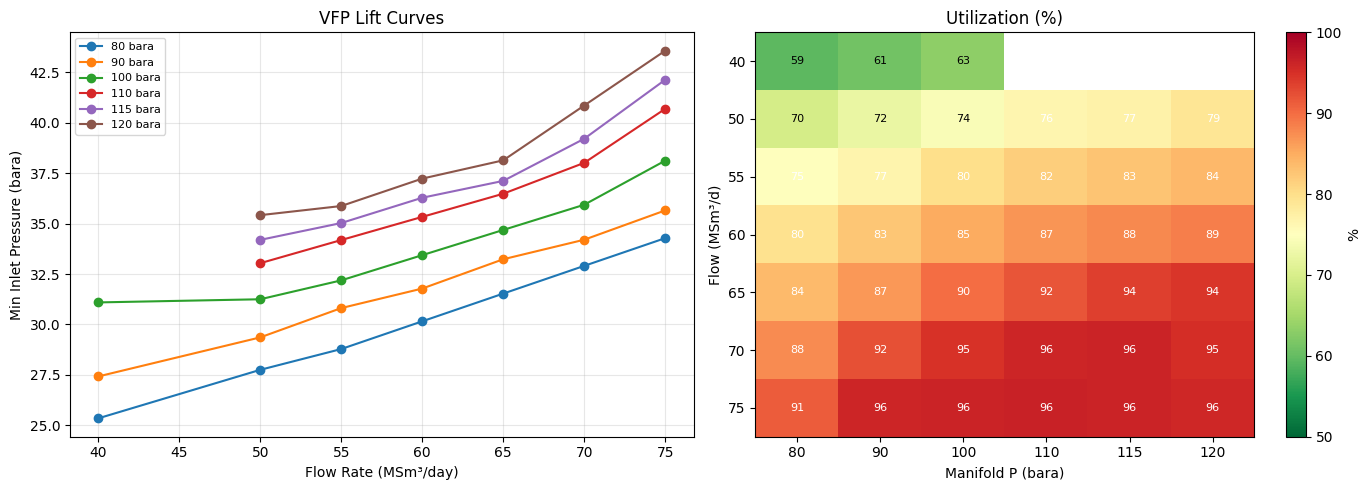

In [4]:
# === RESULTS & VISUALIZATION ===
vfp_df = parallel_df.rename(columns={'p_manifold': 'manifold_pressure_bara', 'min_inlet_p': 'min_inlet_pressure_bara', 
                                      'utilization': 'max_utilization'}).sort_values(['manifold_pressure_bara', 'flow_msm3d'])

# Display pivot table
pivot = vfp_df.pivot(index='flow_msm3d', columns='manifold_pressure_bara', values='min_inlet_pressure_bara')
print("=== MINIMUM INLET PRESSURE (bara) ===")
print("Rows: Flow (MSm³/d), Cols: Manifold P (bara)\n")
print(pivot.to_string())

# Plot VFP curves and utilization heatmap
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

for p in MANIFOLD_PRESSURES:
    df = vfp_df[(vfp_df['manifold_pressure_bara'] == p) & (vfp_df['feasible'])]
    if not df.empty: ax1.plot(df['flow_msm3d'], df['min_inlet_pressure_bara'], 'o-', label=f'{p:.0f} bara', ms=6)
ax1.set_xlabel('Flow Rate (MSm³/day)'); ax1.set_ylabel('Min Inlet Pressure (bara)')
ax1.set_title('VFP Lift Curves'); ax1.legend(fontsize=8); ax1.grid(alpha=0.3)

feas = vfp_df[vfp_df['feasible']]
if not feas.empty:
    piv = feas.pivot(index='flow_msm3d', columns='manifold_pressure_bara', values='max_utilization') * 100
    im = ax2.imshow(piv.values, cmap='RdYlGn_r', aspect='auto', vmin=50, vmax=100)
    ax2.set_xticks(range(len(piv.columns))); ax2.set_xticklabels([f'{p:.0f}' for p in piv.columns])
    ax2.set_yticks(range(len(piv.index))); ax2.set_yticklabels([f'{q:.0f}' for q in piv.index])
    ax2.set_xlabel('Manifold P (bara)'); ax2.set_ylabel('Flow (MSm³/d)'); ax2.set_title('Utilization (%)')
    plt.colorbar(im, ax=ax2, label='%')
    for i in range(len(piv.index)):
        for j in range(len(piv.columns)):
            if not np.isnan(piv.values[i,j]): ax2.text(j, i, f'{piv.values[i,j]:.0f}', ha='center', va='center', 
                                                        color='white' if piv.values[i,j]>75 else 'black', fontsize=8)
plt.tight_layout(); plt.show()

In [6]:
# === ECLIPSE VFP EXPORT WITH POWER ===
import os
os.makedirs(output_dir, exist_ok=True)

def gen_eclipse_vfp(df, tbl=230, datum_depth=0.0):
    """Generate Eclipse VFPPROD table with proper format."""
    flows = sorted(df['flow_msm3d'].unique())
    thps = sorted(df['manifold_pressure_bara'].unique())
    
    # Build BHP matrix and fill missing values with nearest valid value from same row
    bhp_matrix = []
    for thp in thps:
        row = []
        for q in flows:
            match = df[(df['manifold_pressure_bara']==thp) & (df['flow_msm3d']==q) & (df['feasible'])]
            if not match.empty:
                row.append(match['min_inlet_pressure_bara'].values[0])
            else:
                row.append(None)
        bhp_matrix.append(row)
    
    # Fill missing values with nearest valid value from same row
    for i, row in enumerate(bhp_matrix):
        valid_idx = [j for j, v in enumerate(row) if v is not None]
        if valid_idx:
            for j in range(len(row)):
                if row[j] is None:
                    nearest_idx = min(valid_idx, key=lambda x: abs(x - j))
                    row[j] = row[nearest_idx]
    
    # Build Eclipse file - matching example format exactly
    lines = [
        "---------------------------------------------------------------------------",
        "-- Eclipse VFPPROD - Generated " + datetime.now().strftime("%d/%m-%Y"),
        "-- THP = Manifold outlet pressure (bara)",
        "-- BHP = Minimum inlet pressure (bara)", 
        "-- Total compressor power in comment section below",
        "---------------------------------------------------------------------------",
        "VFPPROD",
        "",
        f"  {tbl}  {datum_depth:.0f}  'GAS'  'WGR'  'OGR'  /",
    ]
    
    # Flow rates (Sm3/d) - split across lines if needed, ~6 values per line
    flow_strs = [f"{q*1e6:.2E}" for q in flows]
    for i in range(0, len(flow_strs), 6):
        lines.append("  " + "  ".join(flow_strs[i:i+6]))
    lines.append("/")
    
    # THP values (bara) - single line
    lines.append("  " + "  ".join(f"{p:.0f}" for p in thps))
    lines.append("/")
    
    # WGR, OGR, ALQ - single values
    lines.append("  0")
    lines.append("/")
    lines.append("  0")
    lines.append("/")
    lines.append("  0")
    lines.append("/")
    
    # BHP lines with index prefix (no trailing comments)
    for idx, (thp, row) in enumerate(zip(thps, bhp_matrix), 1):
        bhp_str = "  ".join(f"{v:.2f}" if v is not None else "0.00" for v in row)
        lines.append(f"  {idx}  1  1  1  {bhp_str} /")
    
    # Add power table as comments
    lines += [
        "",
        "-- ================================================",
        "-- TOTAL COMPRESSOR POWER TABLE (MW)",
        "-- Rows: THP (bara), Cols: Flow (MSm3/d)",
        "-- ================================================"
    ]
    header = "-- THP    " + "  ".join(f"{q:6.0f}" for q in flows)
    lines.append(header)
    for thp in thps:
        powers = []
        for q in flows:
            row = df[(df['manifold_pressure_bara']==thp) & (df['flow_msm3d']==q) & (df['feasible'])]
            if not row.empty and 'total_power_MW' in row.columns:
                powers.append(f"{row['total_power_MW'].values[0]:6.1f}")
            else:
                powers.append("   N/A")
        lines.append(f"-- {thp:5.0f}  " + "  ".join(powers))
    lines.append("-- ================================================")
    
    return "\n".join(lines)

eclipse_vfp = gen_eclipse_vfp(vfp_df)
print(eclipse_vfp)

# Save files
with open(f"{output_dir}/VFPPROD_manifold_pressure.INC", 'w') as f: f.write(eclipse_vfp)
vfp_df.to_csv(f"{output_dir}/vfp_manifold_pressure_detailed.csv", index=False)
print(f"\n✓ Saved: {output_dir}/VFPPROD_manifold_pressure.INC, vfp_manifold_pressure_detailed.csv")

---------------------------------------------------------------------------
-- Eclipse VFPPROD - Generated 26/01-2026
-- THP = Manifold outlet pressure (bara)
-- BHP = Minimum inlet pressure (bara)
-- Total compressor power in comment section below
---------------------------------------------------------------------------
VFPPROD

  230  0  'GAS'  'WGR'  'OGR'  /
  1.00E+06  1.00E+07  4.00E+07  5.00E+07  5.50E+07  6.00E+07
  6.50E+07  7.00E+07  7.50E+07
/
  80  90  100  110  115  120
/
  0
/
  0
/
  0
/
  1  1  1  1  25.34  25.34  25.34  27.75  28.78  30.16  31.53  32.91  34.28 /
  2  1  1  1  27.42  27.42  27.42  29.36  30.81  31.78  33.23  34.20  35.66 /
  3  1  1  1  31.09  31.09  31.09  31.25  32.19  33.44  34.69  35.94  38.12 /
  4  1  1  1  33.04  33.04  33.04  33.04  34.19  35.34  36.48  38.02  40.70 /
  5  1  1  1  34.20  34.20  34.20  34.20  35.03  36.29  37.12  39.21  42.14 /
  6  1  1  1  35.42  35.42  35.42  35.42  35.88  37.23  38.14  40.86  43.58 /

-- ==================

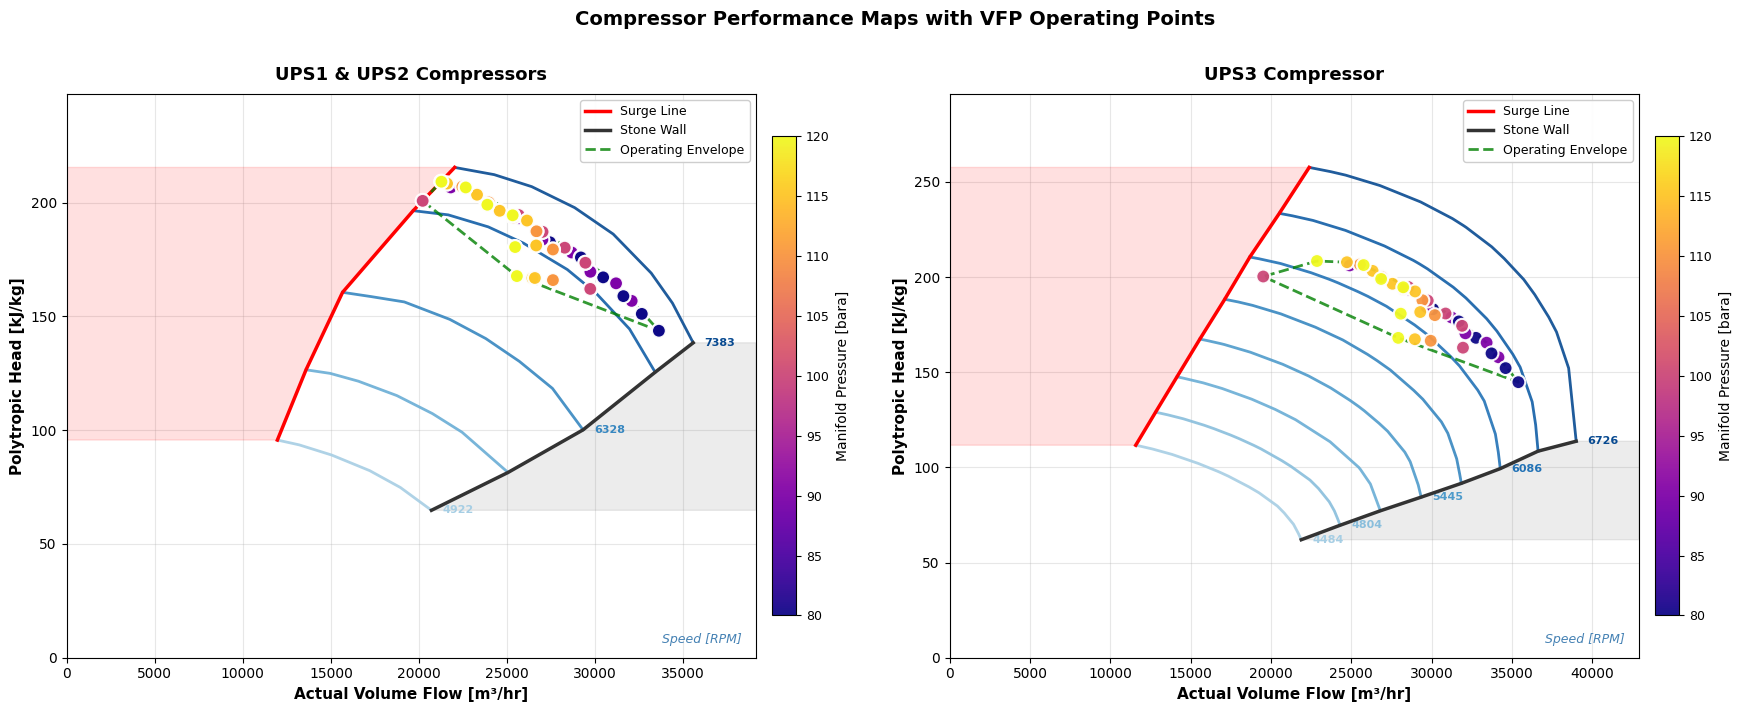


COMPRESSOR OPERATING STATISTICS

UPS1:
  Speed:     6,901 - 7,337 RPM
  Head:      143.7 - 209.2 kJ/kg
  Flow:      20,210 - 33,608 m³/hr
  Power:     26.4 - 42.7 MW

UPS2:
  Speed:     6,901 - 7,337 RPM
  Head:      143.7 - 209.2 kJ/kg
  Flow:      20,208 - 33,618 m³/hr
  Power:     26.4 - 42.7 MW

UPS3:
  Speed:     6,034 - 6,549 RPM
  Head:      144.8 - 208.4 kJ/kg
  Flow:      19,516 - 35,393 m³/hr
  Power:     26.6 - 47.9 MW

✓ Saved: output/compressor_maps.png
✓ Saved: output/compressor_operating_points.csv


In [7]:
# === COMPRESSOR PERFORMANCE MAPS ===
with open(chart_path_1_2) as f: chart_12 = json.load(f)
with open(chart_path_3) as f: chart_3 = json.load(f)

def plot_comp_map(ax, chart, df, title, comp_names):
    """Plot compressor map with speed curves, surge/stonewall regions, and operating points."""
    curves = chart.get('speedCurves', [])
    
    # Extract flows and heads - handle both key naming conventions
    def get_curve_data(c):
        flow = c.get('flow_m3h', c.get('flow', []))
        head = c.get('head_kJkg', c.get('head', []))
        speed = c.get('speed_rpm', c.get('speed', 0))
        return flow, head, speed
    
    # Collect all data for axis limits
    all_flows, all_heads = [], []
    for c in curves:
        f, h, _ = get_curve_data(c)
        all_flows.extend(f)
        all_heads.extend(h)
    
    max_f = max(all_flows) * 1.1 if all_flows else 40000
    max_h = max(all_heads) * 1.15 if all_heads else 250
    min_f, min_h = 0, 0
    
    # Extract surge line (leftmost points of each speed curve) and stone wall (rightmost)
    surge_flows, surge_heads = [], []
    sw_flows, sw_heads = [], []
    for c in curves:
        f, h, spd = get_curve_data(c)
        if f and h:
            # Surge = minimum flow point
            surge_flows.append(min(f))
            surge_heads.append(h[f.index(min(f))])
            # Stone wall = maximum flow point
            sw_flows.append(max(f))
            sw_heads.append(h[f.index(max(f))])
    
    # Sort by head for smooth curves
    if surge_flows:
        surge_sorted = sorted(zip(surge_heads, surge_flows))
        surge_heads, surge_flows = zip(*surge_sorted)
        surge_flows, surge_heads = list(surge_flows), list(surge_heads)
    if sw_flows:
        sw_sorted = sorted(zip(sw_heads, sw_flows))
        sw_heads, sw_flows = zip(*sw_sorted)
        sw_flows, sw_heads = list(sw_flows), list(sw_heads)
    
    # --- SHADED SURGE REGION (red, left side) ---
    if surge_flows and surge_heads:
        poly_x = [min_f] + surge_flows + [min_f]
        poly_y = [surge_heads[0]] + surge_heads + [surge_heads[-1]]
        ax.fill(poly_x, poly_y, color='red', alpha=0.12, zorder=1)
        ax.plot(surge_flows, surge_heads, 'r-', lw=2.5, label='Surge Line', zorder=6)
    
    # --- SHADED STONE WALL REGION (gray, right side) ---
    if sw_flows and sw_heads:
        poly_x = sw_flows + [max_f, max_f, sw_flows[0]]
        poly_y = sw_heads + [sw_heads[-1], sw_heads[0], sw_heads[0]]
        ax.fill(poly_x, poly_y, color='gray', alpha=0.15, zorder=1)
        ax.plot(sw_flows, sw_heads, color='#333', lw=2.5, linestyle='-', label='Stone Wall', zorder=6)
    
    # --- SPEED CURVES with blue gradient ---
    if curves:
        speeds = [get_curve_data(c)[2] for c in curves]
        min_spd, max_spd = min(speeds), max(speeds)
        
        for i, c in enumerate(curves):
            flow, head, spd = get_curve_data(c)
            if flow and head:
                # Color gradient based on speed
                norm = (spd - min_spd) / (max_spd - min_spd) if max_spd > min_spd else 0.5
                color = plt.cm.Blues(0.35 + 0.55 * norm)
                
                ax.plot(flow, head, '-', color=color, lw=2, alpha=0.9, zorder=4)
                
                # Label at end of curve (every other + first and last)
                if i == 0 or i == len(curves)-1 or i % 2 == 0:
                    ax.annotate(f'{spd:.0f}', xy=(flow[-1], head[-1]), xytext=(8, 0), 
                               textcoords='offset points', fontsize=8, color=color, 
                               fontweight='bold', va='center')
    
    # --- OPERATING POINTS ---
    ops = df[df['compressor'].isin(comp_names)]
    if not ops.empty:
        scatter = ax.scatter(ops['actual_flow_m3_hr'], ops['polytropic_head'], 
                            c=ops['p_manifold'], cmap='plasma', s=100, 
                            edgecolors='white', linewidth=1.5, zorder=10, alpha=0.95)
        cbar = plt.colorbar(scatter, ax=ax, shrink=0.85, pad=0.02)
        cbar.set_label('Manifold Pressure [bara]', fontsize=10)
        cbar.ax.tick_params(labelsize=9)
        
        # Convex hull for operating envelope
        try:
            pts = ops[['actual_flow_m3_hr', 'polytropic_head']].values
            if len(pts) >= 3:
                hull = ConvexHull(pts)
                hp = np.vstack([pts[hull.vertices], pts[hull.vertices[0]]])
                ax.plot(hp[:, 0], hp[:, 1], 'g--', lw=2, alpha=0.8, label='Operating Envelope', zorder=8)
        except: pass
    
    # --- STYLING ---
    ax.set_xlabel('Actual Volume Flow [m³/hr]', fontsize=11, fontweight='bold')
    ax.set_ylabel('Polytropic Head [kJ/kg]', fontsize=11, fontweight='bold')
    ax.set_title(title, fontsize=13, fontweight='bold', pad=10)
    ax.set_xlim(min_f, max_f)
    ax.set_ylim(min_h, max_h)
    ax.grid(True, alpha=0.3, linestyle='-', zorder=0)
    ax.set_axisbelow(True)
    ax.legend(loc='upper right', fontsize=9, framealpha=0.95)
    ax.text(0.98, 0.02, 'Speed [RPM]', transform=ax.transAxes, fontsize=9, 
            ha='right', va='bottom', style='italic', color='steelblue')

# Create figure
fig, axes = plt.subplots(1, 2, figsize=(18, 7))
fig.suptitle('Compressor Performance Maps with VFP Operating Points', fontsize=14, fontweight='bold', y=1.01)

plot_comp_map(axes[0], chart_12, map_df, 'UPS1 & UPS2 Compressors', ['UPS1', 'UPS2'])
plot_comp_map(axes[1], chart_3, map_df, 'UPS3 Compressor', ['UPS3'])

plt.tight_layout()
plt.savefig(f"{output_dir}/compressor_maps.png", dpi=200, bbox_inches='tight', facecolor='white')
plt.show()

# Statistics summary
print("\n" + "="*70)
print("COMPRESSOR OPERATING STATISTICS")
print("="*70)
for n in ['UPS1', 'UPS2', 'UPS3']:
    d = map_df[map_df['compressor'] == n]
    if not d.empty:
        print(f"\n{n}:")
        print(f"  Speed:     {d['speed'].min():,.0f} - {d['speed'].max():,.0f} RPM")
        print(f"  Head:      {d['polytropic_head'].min():.1f} - {d['polytropic_head'].max():.1f} kJ/kg")
        print(f"  Flow:      {d['actual_flow_m3_hr'].min():,.0f} - {d['actual_flow_m3_hr'].max():,.0f} m³/hr")
        print(f"  Power:     {d['power_MW'].min():.1f} - {d['power_MW'].max():.1f} MW")

map_df.to_csv(f"{output_dir}/compressor_operating_points.csv", index=False)
print(f"\n✓ Saved: {output_dir}/compressor_maps.png")
print(f"✓ Saved: {output_dir}/compressor_operating_points.csv")